In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import os
import copy

plt.ion()  

use_gpu = torch.cuda.is_available()

# device = torch.device('cpu')
device = None
if use_gpu:
    device = torch.device('cuda:0')
    print("Using CUDA")
else:
    device = torch.device('cpu')
    print("Using CPU")
    
torch.manual_seed(54)

Using CUDA


In [2]:
# !pip install gputil

# import torch
# from GPUtil import showUtilization as gpu_usage
# from numba import cuda

# def free_gpu_cache():
#     print("Initial GPU Usage")
#     gpu_usage()                             

#     torch.cuda.empty_cache()

#     cuda.select_device(0)
#     cuda.close()
#     cuda.select_device(0)

#     print("GPU Usage after emptying the cache")
#     gpu_usage()

# free_gpu_cache()  

 # ****Data preprocessing****

In [3]:
df = pd.read_csv('/kaggle/input/nih-chest-x-ray-14-224x224-resized/Data_Entry_2017.csv')

df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,081Y,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,081Y,F,PA,2582,2991,0.143,0.143,NaN


In [4]:
df.describe()

,Follow-up #,Patient ID,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,8.573751,14346.381743,2646.078844,2486.438842,0.155649,0.155649,NaN
std,15.406320,8403.876972,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7310.750000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


In [5]:
df.count()

Image Index                    112120
Finding Labels                 112120
Follow-up #                    112120
Patient ID                     112120
Patient Age                    112120
Patient Gender                 112120
View Position                  112120
OriginalImage[Width            112120
Height]                        112120
OriginalImagePixelSpacing[x    112120
y]                             112120
Unnamed: 11                         0
dtype: int64

In [6]:
df[df['Image Index'].isna()].count()

Image Index                    0
Finding Labels                 0
Follow-up #                    0
Patient ID                     0
Patient Age                    0
Patient Gender                 0
View Position                  0
OriginalImage[Width            0
Height]                        0
OriginalImagePixelSpacing[x    0
y]                             0
Unnamed: 11                    0
dtype: int64

In [7]:
df[df['Finding Labels'] == 'No Finding'].count()

Image Index                    60412
Finding Labels                 60412
Follow-up #                    60412
Patient ID                     60412
Patient Age                    60412
Patient Gender                 60412
View Position                  60412
OriginalImage[Width            60412
Height]                        60412
OriginalImagePixelSpacing[x    60412
y]                             60412
Unnamed: 11                        0
dtype: int64

In [8]:
# df = df.drop(df[df['Finding Labels'] == 'No Finding'].index)

In [9]:
labels = ['atelectasis', 'cardiomegaly', 'consolidation', 'edema', 'effusion', 'emphysema', 'fibrosis',
          'hernia', 'infiltration', 'mass', 'nodule', 'pleural_thickening', 'pneumonia', 'pneumothorax']

In [10]:
len(labels)

14

In [11]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,081Y,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,081Y,F,PA,2582,2991,0.143,0.143,NaN


In [12]:
df = df.drop(df.columns.difference(['Image Index', 'Finding Labels']), axis=1)

In [13]:
from sklearn.preprocessing import MultiLabelBinarizer
label_mlb = []
for label in df['Finding Labels'].values:
    splits = label.split('|')
    label_mlb.append(set(splits))

mlb = MultiLabelBinarizer()
label_array = mlb.fit_transform(label_mlb)

In [14]:
mlb.classes_

array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'], dtype=object)

In [15]:
final_df = pd.DataFrame(label_array, columns=mlb.classes_)
final_df.insert(loc=0, column='Image', value=df['Image Index'].values)
final_df.head()
images = final_df['Image']
is_healthy = final_df['No Finding']

final_df = pd.DataFrame()
final_df['Image'] = images
is_sick = [int(not bool(item)) for item in is_healthy]
final_df['Is Sick'] = is_sick
final_df

,Image,Is Sick
0,00000001_000.png,1
1,00000001_001.png,1
2,00000001_002.png,1
3,00000002_000.png,0
4,00000003_000.png,1
...,...,...
112115,00030801_001.png,1
112116,00030802_000.png,0
112117,00030803_000.png,0
112118,00030804_000.png,0


In [16]:
labels = ['is_sick']

#  Creating dataset

In [17]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [18]:

class ChestXRayDataset(Dataset):
    def __init__(self, root, df, transform=None):
        self.root = root
        self.df = df
        self.transform = transform
        
        file = open(self.root)
        images = file.read().splitlines()
        
        ids = []
        
        for idx, path in enumerate(self.df['Image']):
            if path in images:
                ids.append(idx)
        
        self.df = self.df.iloc[ids, :].reset_index(drop=True)
        self.images = self.df['Image'].values
        self.labels = self.df.iloc[:, 1:].values
    
        labels = list(map(lambda x: x.lower(), self.df.columns[1:]))
        self.classes = {v: k for k, v in enumerate(labels)}
        
    def __getitem__(self, item):
        img = Image.open(
            f'/kaggle/input/nih-chest-x-ray-14-224x224-resized/images-224/images-224/{self.images[item]}'
        )
#         img = np.expand_dims(img, axis=-1)
#         img = img.repeat(3, axis=-1)
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img, torch.tensor(self.labels[item], dtype=torch.float32)
    
    def __len__(self):
        return len(self.df)

In [19]:
basic_transform = torchvision.transforms.Compose([
                                          torchvision.transforms.Grayscale(num_output_channels=3), 
                                          torchvision.transforms.Resize((299, 299)),
                                          torchvision.transforms.ToTensor()
                                          ])

In [20]:
train_dataset = ChestXRayDataset(
    root='/kaggle/input/nih-chest-x-ray-14-224x224-resized/train_val_list_NIH.txt',
    df=final_df,
    transform=basic_transform
)

In [21]:
test_dataset = ChestXRayDataset(
    root='/kaggle/input/nih-chest-x-ray-14-224x224-resized/test_list_NIH.txt',
    df=final_df,
    transform=basic_transform
)

In [22]:
len(train_dataset), train_dataset[0]

(86524,
 (tensor([[[0.7529, 0.7373, 0.7020,  ..., 0.0196, 0.0196, 0.0157],
           [0.7294, 0.6980, 0.6275,  ..., 0.0196, 0.0196, 0.0157],
           [0.6902, 0.6235, 0.5098,  ..., 0.0196, 0.0196, 0.0157],
           ...,
           [0.9882, 0.9333, 0.8353,  ..., 0.0078, 0.0000, 0.0000],
           [0.9882, 0.9333, 0.8353,  ..., 0.0118, 0.0000, 0.0000],
           [0.9922, 0.9373, 0.8392,  ..., 0.0157, 0.0000, 0.0000]],
  
          [[0.7529, 0.7373, 0.7020,  ..., 0.0196, 0.0196, 0.0157],
           [0.7294, 0.6980, 0.6275,  ..., 0.0196, 0.0196, 0.0157],
           [0.6902, 0.6235, 0.5098,  ..., 0.0196, 0.0196, 0.0157],
           ...,
           [0.9882, 0.9333, 0.8353,  ..., 0.0078, 0.0000, 0.0000],
           [0.9882, 0.9333, 0.8353,  ..., 0.0118, 0.0000, 0.0000],
           [0.9922, 0.9373, 0.8392,  ..., 0.0157, 0.0000, 0.0000]],
  
          [[0.7529, 0.7373, 0.7020,  ..., 0.0196, 0.0196, 0.0157],
           [0.7294, 0.6980, 0.6275,  ..., 0.0196, 0.0196, 0.0157],
           [0.

# Dealing with class imbalance

In [23]:
len(train_dataset)

86524

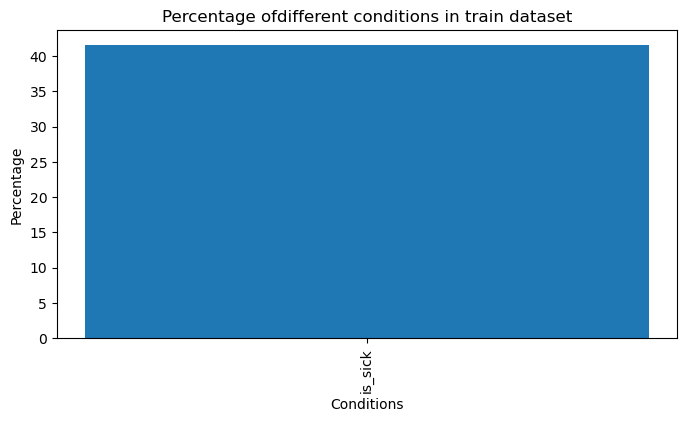

In [24]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,4))
plt.xticks(rotation = 90)
plt.bar(labels, train_dataset.labels.sum(axis = 0)/len(train_dataset) * 100)
plt.title('Percentage ofdifferent conditions in train dataset')
plt.xlabel('Conditions')
plt.ylabel('Percentage')
plt.show()

/tmp/ipykernel_28/1385432927.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)


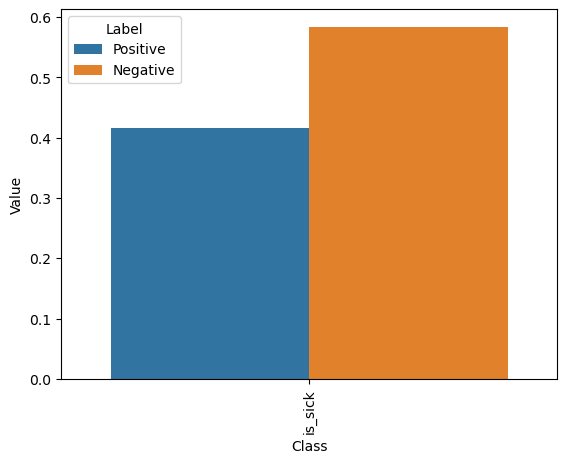

In [25]:
import seaborn as sns
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """    
    # total number of patients (rows)
    N = labels.shape[0]
    positive_frequencies = (labels.sum(axis = 0))/N
    negative_frequencies = 1.0 - positive_frequencies
    
    return positive_frequencies, negative_frequencies


# calulating and plotting the imbalanced classes
freq_pos, freq_neg = compute_class_freqs(train_dataset.labels)
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

/tmp/ipykernel_28/1490179493.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v}


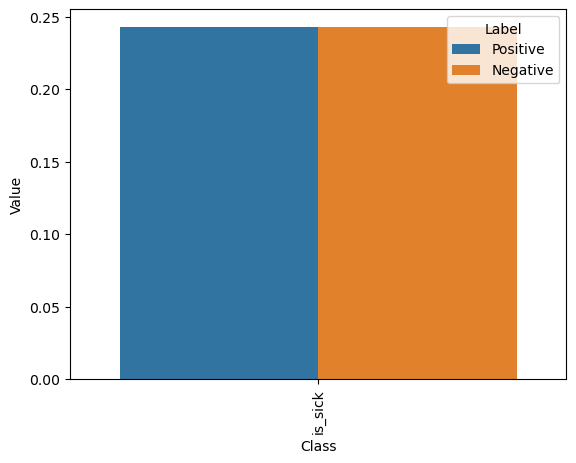

In [26]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights
pos_weights


data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [27]:
class WeightedLoss(nn.Module):
    def __init__(self):
        super(WeightedLoss, self).__init__()

    def forward(self, y_pred, y_true):
#         y_true = torch.LongTensor(y_true)
        loss = 0.0
        epsilon = 1e-9
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss_pos = -1 * torch.mean(pos_weights[i] * y_true[:, i] * torch.log(y_pred[:, i] + epsilon))
            loss_neg = -1 * torch.mean(neg_weights[i] * (1 - y_true[:, i]) * torch.log(1 - y_pred[:, i] + epsilon))
            loss += loss_pos + loss_neg
        return loss

In [28]:
# cr = WeightedLoss()
# cr(torch.tensor([[1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0], 
#                  [0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1]]),
#    torch.tensor([[1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
#                  [0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1]]))

# Function that returns balanced accuracies, recall and precision

In [29]:
from sklearn.metrics import balanced_accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=UserWarning)
from sklearn.metrics import precision_score, recall_score

def get_classes_accuracy_and_pr(loader, model):
    model.eval()
    total_balanced_acc = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    
    y_true = []
    y_pred = []
    
    for images, labels in tqdm(loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = nn.Sigmoid()(model(images)).to(DEVICE)
        batch_balanced_accuracies = []

        np_labels = labels.cpu().detach().numpy()
        np_outputs = outputs.cpu().detach().numpy()
        for k in range(len(np_outputs)):
            for j in range(len(np_outputs[k])):
                np_outputs[k][j] = 1 if np_outputs[k][j] > THRESHOLD else 0

        y_true.extend(list(np_labels))
        y_pred.extend(list(np_outputs))
        
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    for i in range(len(outputs[0])):
        bal_acc = balanced_accuracy_score(y_true[:, i], y_pred[:, i])
        total_balanced_acc.append(bal_acc)
        
        precision = precision_score(y_true[:, i], y_pred[:, i])
        precision_scores.append(precision)
        
        recall = recall_score(y_true[:, i], y_pred[:, i])
        recall_scores.append(recall)
        
        f1 = f1_score(y_true[:, i], y_pred[:, i])
        f1_scores.append(f1)
        
#         cm = confusion_matrix(y_true[:, i], y_pred[:, i], labels=mlb.classes)
#         disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                                       display_labels=mlb.classes)
#         disp.plot()
            
#             bal_acc = balanced_accuracy_score(np_labels[:, i], np_outputs[:, i])
#             batch_balanced_accuracies.append(bal_acc)
#         total_balanced_acc.append(batch_balanced_accuracies)
    
#     mean_acc = np.mean(total_balanced_acc, axis=0)
#     print(len(total_balanced_acc))
#     print(mean_acc)
    return total_balanced_acc, precision_scores, recall_scores, f1_scores

In [30]:
def get_predictions_and_labels(loader, model):
    model.eval()
    total_balanced_acc = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    
    y_true = []
    y_pred = []
    y_probs = []
    
    for images, labels in tqdm(loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = nn.Sigmoid()(model(images)).to(DEVICE)
        batch_balanced_accuracies = []

        np_labels = labels.cpu().detach().numpy()
        np_outputs = outputs.cpu().detach().numpy()
        y_probs.extend(list(np_outputs.copy()))
        
        for k in range(len(np_outputs)):
            for j in range(len(np_outputs[k])):
                np_outputs[k][j] = 1 if np_outputs[k][j] > THRESHOLD else 0

        y_true.extend(list(np_labels))
        y_pred.extend(list(np_outputs))
        
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)
    
    return y_true, y_pred, y_probs

# Training ResNet34

In [31]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# DEVICE = 'cpu'

BATCH_SIZE = 32
LEARNING_RATE = 1e-6
PIN_MEMORY = False
EPOCHS = 10
THRESHOLD = 0.5

In [32]:
print(DEVICE)

cuda


In [33]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=PIN_MEMORY,
    shuffle=True,
    drop_last=False,
)

In [34]:
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=int(BATCH_SIZE/2),
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

In [35]:
def train_epoch(loader, model, optimizer, loss_fn, epoch):
    model.train()
    
    losses = []
    i = 0
    running_loss = 0.
    for images, labels, in tqdm(loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        outputs = nn.Sigmoid()(model(images)).to(DEVICE)
        loss = loss_fn(outputs, labels)
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 200 == 199:
            last_loss = running_loss / 200 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.
        i += 1
        
    print(f'=> Epoch[{epoch}]: Mean Loss = {np.mean(losses)}')
    torch.save(model.state_dict(), f'./weighted_bce_loss_weights{epoch}.pt')
    
    return np.mean(losses)

In [49]:
resnet = torchvision.models.resnet34(pretrained=True)
resnet.fc = nn.Linear(in_features=512, out_features=1, bias=True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 267MB/s]


In [53]:
# vgg16.classifier.add_module('7', nn.Sigmoid())

In [54]:
# model.add_module('Sigmoid', nn.Sigmoid())

In [50]:
resnet.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [106]:
# optimizer = optim.Adam(resnet.parameters(), lr=1e-6, weight_decay=1e-9)
optimizer = optim.SGD(resnet.parameters(), lr=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, 3, gamma=0.1)
loss_fn = nn.BCELoss()

In [60]:
with torch.no_grad():
        class_accuracies_pretrained, precisions_pretrained, recalls_pretrained, f1_pretrained = get_classes_accuracy_and_pr(test_loader, resnet)
        print(f'accuracies: {class_accuracies_pretrained}')
        print(f'mean accuracy: {np.mean(class_accuracies_pretrained)}\n')
        
        print(f'precisions: {precisions_pretrained}')
        print(f'mean precision: {np.mean(precisions_pretrained)}\n')
        
        print(f'recalls: {recalls_pretrained}')
        print(f'mean recall: {np.mean(recalls_pretrained)}\n')
        
        print(f'f1: {f1_pretrained}')
        print(f'mean f1: {np.mean(f1_pretrained)}\n')

100%|██████████| 1600/1600 [02:35<00:00, 10.31it/s]

accuracies: [0.5090330099983141]
mean accuracy: 0.5090330099983141

precisions: [0.6439329354930378]
mean precision: 0.6439329354930378

recalls: [0.14447844937515938]
mean recall: 0.14447844937515938

f1: [0.23600479091808568]
mean f1: 0.23600479091808568



In [50]:
# losses = []

# accuracies_by_epochs = []

# precs_by_epochs = []

# recs_by_epochs = []

# f1_by_epochs = []

In [110]:
best_resnet_f1 = 0.768

In [108]:
for epoch in range(25):
    loss = train_epoch(
        train_loader,
        resnet,
        optimizer,
        loss_fn,
        epoch + 1
    )
    
    with torch.no_grad():
        accs, precs, recs, f1 = get_classes_accuracy_and_pr(test_loader, resnet)
        print(f'epoch {epoch + 1} classes balanced accuracies:')
        print(f'accuracy: {accs}')
#         print(f'mean accuracy: {np.mean(accs)}\n')
        
        print(f'precision: {precs}')
#         print(f'mean precision: {np.mean(precs)}\n')
        
        print(f'recall: {recs}')
#         print(f'mean recall: {np.mean(recs)}\n')
        
        print(f'f1: {f1}')
#         print(f'mean f1: {np.mean(f1)}\n')
        
        
        accuracies_by_epochs.append(accs[0])
        
        precs_by_epochs.append(precs[0])

        recs_by_epochs.append(recs[0])
        
        f1_by_epochs.append(f1[0])
        
        torch.save(accuracies_by_epochs, './accuracies_by_epochs.pt')
        torch.save(precs_by_epochs, './precs_by_epochs.pt')
        torch.save(recs_by_epochs, './recs_by_epochs.pt')
        torch.save(f1_by_epochs, './f1_by_epochs.pt')
        
        if f1[0] > best_resnet_f1:
            torch.save(resnet.state_dict(), f'./weights_f1_{np.mean(f1)}.pt')
            best_resnet_f1 = f1[0]
        
    losses.append(loss)

  7%|▋         | 200/2704 [01:01<12:33,  3.32it/s]

  batch 200 loss: 0.5436835661530495


 15%|█▍        | 400/2704 [02:03<11:32,  3.33it/s]

  batch 400 loss: 0.5317629911005497


 19%|█▉        | 522/2704 [02:41<11:14,  3.23it/s]


KeyboardInterrupt: 

# Evaluating ResNet34

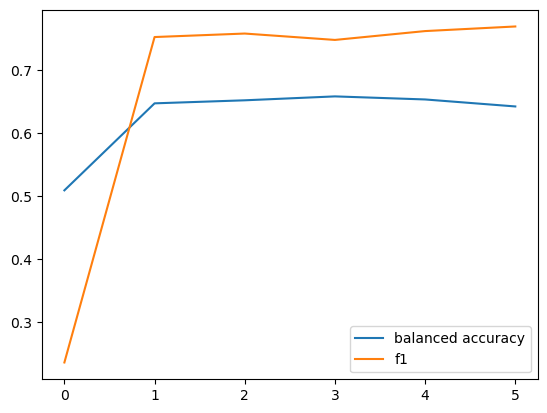

In [64]:
from matplotlib import pyplot as plt
num_epochs = 5

plt.plot(range(num_epochs + 1), [class_accuracies_pretrained[0], *accuracies_by_epochs[:num_epochs]],
        label='balanced accuracy')
plt.plot(range(num_epochs + 1), [f1_pretrained[0], *f1_by_epochs[:num_epochs]],
        label='f1')
plt.xlabel('epoch')
plt.ylabel('rate')
plt.legend()

In [58]:
resnet.load_state_dict(torch.load('/kaggle/working/weights_f1_0.7689501418727199.pt'))

<All keys matched successfully>

In [98]:
with torch.no_grad():
    y_true, y_pred, y_probs = get_predictions_and_labels(test_loader, resnet)

100%|██████████| 1600/1600 [02:25<00:00, 11.02it/s]


In [99]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

0.6882325363338021


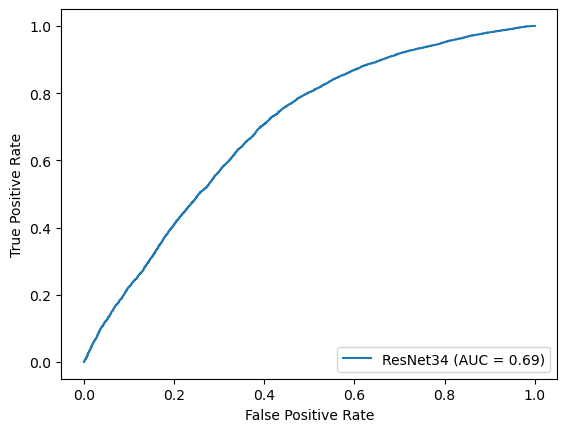

In [101]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_true, y_probs)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='ResNet34')
display.plot()

plt.show()

In [36]:
class_accs = torch.load('/kaggle/working/class_accuracies_by_epochs.pt')
mean_accs = torch.load('/kaggle/working/mean_accuracies_by_epochs.pt')
class_precs = torch.load('/kaggle/working/class_precs_by_epochs.pt')
mean_precs = torch.load('/kaggle/working/mean_precs_by_epochs.pt')
class_recs = torch.load('/kaggle/working/class_recs_by_epochs.pt')
mean_recs = torch.load('/kaggle/working/mean_recs_by_epochs.pt')

# Training DenseNet121

In [47]:
densenet = torchvision.models.densenet121(pretrained=True)
densenet.fc = nn.Linear(in_features=512, out_features=1, bias=True)
densenet.classifier = nn.Linear(in_features=1024, out_features=1, bias=True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 71.2MB/s]


In [48]:
densenet.to(DEVICE)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [41]:
optimizer = optim.SGD(densenet.parameters(), lr=1e-4, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, 3, gamma=0.1)
loss_fn = nn.BCELoss()

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score

with torch.no_grad():
        y_true, y_pred, y_probs = get_predictions_and_labels(test_loader, densenet)
        
        dn_acc_pretrained = accuracy_score(y_true, y_pred)
        print(f'accuracy: {dn_acc_pretrained}\n')
        
        dn_bal_acc_pretrained = balanced_accuracy_score(y_true, y_pred)
        print(f'balanced accuracy: {dn_bal_acc_pretrained}\n')
        
        dn_prec_pretrained = precision_score(y_true, y_pred)
        print(f'precision: {dn_prec_pretrained}\n')
        
        dn_rec_pretrained = recall_score(y_true, y_pred)
        print(f'recall: {dn_rec_pretrained}\n')

        dn_f1_pretrained = f1_score(y_true, y_pred)
        print(f'f1: {dn_f1_pretrained}\n')

100%|██████████| 1600/1600 [03:04<00:00,  8.67it/s]

accuracy: 0.6127910611032974

balanced accuracy: 0.5000504439063761

precision: 0.6127759327993749

recall: 1.0

f1: 0.7599021294120497



In [54]:
best_densenet_f1 = 0.49

In [55]:
dn_losses = []

dn_accs_by_epochs = []

dn_bal_accs_by_epochs = []

dn_precs_by_epochs = []

dn_recs_by_epochs = []

dn_f1_by_epochs = []

In [56]:
for epoch in range(25):
    loss = train_epoch(
        train_loader,
        densenet,
        optimizer,
        loss_fn,
        epoch + 1
    )
    
    with torch.no_grad():
        y_true, y_pred, y_probs = get_predictions_and_labels(test_loader, densenet)
        
        dn_acc = accuracy_score(y_true, y_pred)
        
        print(f'accuracy: {dn_acc}\n')
        
        dn_bal_acc = balanced_accuracy_score(y_true, y_pred)
        
        print(f'balanced accuracy: {dn_bal_acc}\n')
        
        dn_prec = precision_score(y_true, y_pred)
        
        print(f'precision: {dn_prec}\n')
        
        dn_rec = recall_score(y_true, y_pred)
        
        print(f'recall: {dn_rec}\n')
        
        dn_f1 = f1_score(y_true, y_pred)

        print(f'f1: {dn_f1}\n')
        
        
        dn_bal_accs_by_epochs.append(dn_bal_acc)
        dn_accs_by_epochs.append(dn_acc)
        dn_precs_by_epochs.append(dn_prec)
        dn_recs_by_epochs.append(dn_rec)
        dn_f1_by_epochs.append(dn_f1)
        
        torch.save(dn_bal_accs_by_epochs, './dn_bal_accs_by_epochs.pt')
        torch.save(dn_accs_by_epochs, './dn_accs_by_epochs.pt')
        torch.save(dn_precs_by_epochs, './dn_precs_by_epochs.pt')
        torch.save(dn_recs_by_epochs, './dn_recs_by_epochs.pt')
        torch.save(dn_f1_by_epochs, './dn_f1_by_epochs.pt')
        
        if dn_f1 > best_densenet_f1:
            torch.save(densenet.state_dict(), f'./dn_weights_f1_{np.mean(dn_f1)}.pt')
            best_densenet_f1 = dn_f1
        
    dn_losses.append(loss)

  7%|▋         | 200/2704 [01:32<18:57,  2.20it/s]

  batch 200 loss: 0.6402662470936775


 15%|█▍        | 400/2704 [03:05<17:43,  2.17it/s]

  batch 400 loss: 0.6240369495749474


 22%|██▏       | 600/2704 [04:39<16:45,  2.09it/s]

  batch 600 loss: 0.6147072450816631


 30%|██▉       | 800/2704 [06:12<14:35,  2.17it/s]

  batch 800 loss: 0.6218648116290569


 37%|███▋      | 1000/2704 [07:45<13:07,  2.17it/s]

  batch 1000 loss: 0.6178141911327839


 44%|████▍     | 1200/2704 [09:18<11:51,  2.11it/s]

  batch 1200 loss: 0.6156406597793103


 52%|█████▏    | 1400/2704 [10:51<09:59,  2.18it/s]

  batch 1400 loss: 0.611063361465931


 59%|█████▉    | 1600/2704 [12:24<08:39,  2.12it/s]

  batch 1600 loss: 0.6054601660370826


 67%|██████▋   | 1800/2704 [13:57<06:56,  2.17it/s]

  batch 1800 loss: 0.6001859797537327


 74%|███████▍  | 2000/2704 [15:31<05:26,  2.16it/s]

  batch 2000 loss: 0.6032482179999351


 81%|████████▏ | 2200/2704 [17:04<03:52,  2.17it/s]

  batch 2200 loss: 0.5965472993254661


 89%|████████▉ | 2400/2704 [18:37<02:20,  2.17it/s]

  batch 2400 loss: 0.5973786374926567


 96%|█████████▌| 2600/2704 [20:11<00:48,  2.16it/s]

  batch 2600 loss: 0.6093257023394107


100%|██████████| 2704/2704 [20:59<00:00,  2.15it/s]


=> Epoch[1]: Mean Loss = 0.6120264697158654


100%|██████████| 1600/1600 [03:31<00:00,  7.57it/s]


accuracy: 0.6606501015783717

balanced accuracy: 0.6452164279014161

precision: 0.7273849753054328

recall: 0.7136572302983932

f1: 0.7204557157569517



  7%|▋         | 200/2704 [01:30<18:36,  2.24it/s]

  batch 200 loss: 0.5933425110578537


 15%|█▍        | 400/2704 [03:00<17:13,  2.23it/s]

  batch 400 loss: 0.5904283985495568


 22%|██▏       | 600/2704 [04:31<15:44,  2.23it/s]

  batch 600 loss: 0.5913667078316212


 30%|██▉       | 800/2704 [06:02<15:13,  2.08it/s]

  batch 800 loss: 0.5893105021119118


 37%|███▋      | 1000/2704 [07:34<12:49,  2.22it/s]

  batch 1000 loss: 0.6006089262664318


 44%|████▍     | 1200/2704 [09:09<11:56,  2.10it/s]

  batch 1200 loss: 0.580941958874464


 52%|█████▏    | 1400/2704 [10:41<09:55,  2.19it/s]

  batch 1400 loss: 0.5927754920721054


 59%|█████▉    | 1600/2704 [12:13<08:28,  2.17it/s]

  batch 1600 loss: 0.5957559870183468


 67%|██████▋   | 1800/2704 [13:47<07:07,  2.11it/s]

  batch 1800 loss: 0.603346254080534


 74%|███████▍  | 2000/2704 [15:20<05:25,  2.16it/s]

  batch 2000 loss: 0.5932942974567413


 81%|████████▏ | 2200/2704 [16:55<03:51,  2.17it/s]

  batch 2200 loss: 0.5842719718813896


 89%|████████▉ | 2400/2704 [18:28<02:19,  2.17it/s]

  batch 2400 loss: 0.5903439126908779


 96%|█████████▌| 2600/2704 [20:01<00:47,  2.19it/s]

  batch 2600 loss: 0.5908888910710811


100%|██████████| 2704/2704 [20:50<00:00,  2.16it/s]


=> Epoch[2]: Mean Loss = 0.5919675759464149


100%|██████████| 1600/1600 [03:30<00:00,  7.59it/s]


accuracy: 0.6924519456165026

balanced accuracy: 0.6595451989751588

precision: 0.7237882433826057

recall: 0.8054705432287682

f1: 0.7624479449574507



  7%|▋         | 200/2704 [01:28<18:50,  2.22it/s]

  batch 200 loss: 0.5811812150478363


 15%|█▍        | 400/2704 [02:57<16:58,  2.26it/s]

  batch 400 loss: 0.5767600929737091


 22%|██▏       | 600/2704 [04:27<15:46,  2.22it/s]

  batch 600 loss: 0.5818529377877713


 30%|██▉       | 800/2704 [05:58<14:19,  2.22it/s]

  batch 800 loss: 0.5790596979856492


 37%|███▋      | 1000/2704 [07:29<12:48,  2.22it/s]

  batch 1000 loss: 0.5870954184234143


 44%|████▍     | 1200/2704 [09:00<11:25,  2.19it/s]

  batch 1200 loss: 0.5827041578292846


 52%|█████▏    | 1400/2704 [10:31<09:54,  2.19it/s]

  batch 1400 loss: 0.5823909428715706


 59%|█████▉    | 1600/2704 [12:03<08:32,  2.15it/s]

  batch 1600 loss: 0.5819146046042443


 67%|██████▋   | 1800/2704 [13:34<07:35,  1.99it/s]

  batch 1800 loss: 0.5801618738472462


 74%|███████▍  | 2000/2704 [15:05<05:15,  2.23it/s]

  batch 2000 loss: 0.5794897212088108


 81%|████████▏ | 2200/2704 [16:37<04:35,  1.83it/s]

  batch 2200 loss: 0.57259501516819


 89%|████████▉ | 2400/2704 [18:09<02:22,  2.13it/s]

  batch 2400 loss: 0.5800742396712303


 96%|█████████▌| 2600/2704 [19:40<00:46,  2.23it/s]

  batch 2600 loss: 0.5894255109131337


100%|██████████| 2704/2704 [20:28<00:00,  2.20it/s]


=> Epoch[3]: Mean Loss = 0.5810331262030898


100%|██████████| 1600/1600 [03:28<00:00,  7.66it/s]


accuracy: 0.6884278793561494

balanced accuracy: 0.6550177908363298

precision: 0.7204460966542751

recall: 0.8031752104055088

f1: 0.7595646537429528



  7%|▋         | 200/2704 [01:29<18:43,  2.23it/s]

  batch 200 loss: 0.572594961822033


 15%|█▍        | 400/2704 [03:02<17:04,  2.25it/s]

  batch 400 loss: 0.5739653195440769


 22%|██▏       | 600/2704 [04:35<18:24,  1.91it/s]

  batch 600 loss: 0.577468221783638


 30%|██▉       | 800/2704 [06:09<14:52,  2.13it/s]

  batch 800 loss: 0.5654529665410518


 37%|███▋      | 1000/2704 [07:43<12:50,  2.21it/s]

  batch 1000 loss: 0.5716453166306019


 44%|████▍     | 1200/2704 [09:17<11:19,  2.21it/s]

  batch 1200 loss: 0.5724697867035866


 52%|█████▏    | 1400/2704 [10:52<10:01,  2.17it/s]

  batch 1400 loss: 0.5625584444403648


 59%|█████▉    | 1600/2704 [12:26<08:28,  2.17it/s]

  batch 1600 loss: 0.574548836350441


 67%|██████▋   | 1800/2704 [13:57<06:48,  2.22it/s]

  batch 1800 loss: 0.57488934263587


 74%|███████▍  | 2000/2704 [15:28<05:25,  2.17it/s]

  batch 2000 loss: 0.5801982416212559


 81%|████████▏ | 2200/2704 [17:00<03:49,  2.20it/s]

  batch 2200 loss: 0.5690343476831913


 89%|████████▉ | 2400/2704 [18:31<02:19,  2.18it/s]

  batch 2400 loss: 0.5734695948660373


 96%|█████████▌| 2600/2704 [20:04<00:46,  2.23it/s]

  batch 2600 loss: 0.5671443103253841


100%|██████████| 2704/2704 [20:51<00:00,  2.16it/s]


=> Epoch[4]: Mean Loss = 0.5718733320707048


100%|██████████| 1600/1600 [03:31<00:00,  7.56it/s]


accuracy: 0.689443663072355

balanced accuracy: 0.6611560461981273

precision: 0.72831926323868

recall: 0.7865978066819689

f1: 0.75633755325997



  7%|▋         | 200/2704 [01:29<18:33,  2.25it/s]

  batch 200 loss: 0.559263740926981


 15%|█▍        | 400/2704 [02:59<17:51,  2.15it/s]

  batch 400 loss: 0.5636309802532196


 22%|██▏       | 600/2704 [04:30<15:49,  2.22it/s]

  batch 600 loss: 0.5616066788136959


 30%|██▉       | 800/2704 [06:00<15:16,  2.08it/s]

  batch 800 loss: 0.5668199542164802


 37%|███▋      | 1000/2704 [07:32<12:48,  2.22it/s]

  batch 1000 loss: 0.5579643969237804


 44%|████▍     | 1200/2704 [09:03<11:37,  2.16it/s]

  batch 1200 loss: 0.5608464726805686


 52%|█████▏    | 1400/2704 [10:34<09:50,  2.21it/s]

  batch 1400 loss: 0.5612449979782105


 59%|█████▉    | 1600/2704 [12:07<08:23,  2.19it/s]

  batch 1600 loss: 0.5649385857582092


 67%|██████▋   | 1800/2704 [13:39<06:52,  2.19it/s]

  batch 1800 loss: 0.5653284311294555


 74%|███████▍  | 2000/2704 [15:10<05:20,  2.20it/s]

  batch 2000 loss: 0.5631497205793857


 81%|████████▏ | 2200/2704 [16:41<03:45,  2.24it/s]

  batch 2200 loss: 0.5763887470960617


 89%|████████▉ | 2400/2704 [18:12<02:20,  2.16it/s]

  batch 2400 loss: 0.5608957719802856


 96%|█████████▌| 2600/2704 [19:43<00:47,  2.21it/s]

  batch 2600 loss: 0.5625943572819233


100%|██████████| 2704/2704 [20:31<00:00,  2.20it/s]


=> Epoch[5]: Mean Loss = 0.5633166158384473


100%|██████████| 1600/1600 [03:31<00:00,  7.58it/s]


accuracy: 0.6881934677293327

balanced accuracy: 0.656942841457774

precision: 0.72326241956988

recall: 0.7955241009946442

f1: 0.7576742067709125



  7%|▋         | 200/2704 [01:28<18:26,  2.26it/s]

  batch 200 loss: 0.5517455005645752


 15%|█▍        | 400/2704 [02:57<17:43,  2.17it/s]

  batch 400 loss: 0.5650637373328209


 22%|██▏       | 600/2704 [04:30<15:46,  2.22it/s]

  batch 600 loss: 0.5538580891489983


 30%|██▉       | 800/2704 [06:01<14:53,  2.13it/s]

  batch 800 loss: 0.5477798680961132


 37%|███▋      | 1000/2704 [07:34<12:34,  2.26it/s]

  batch 1000 loss: 0.5442459611594677


 44%|████▍     | 1200/2704 [09:08<11:20,  2.21it/s]

  batch 1200 loss: 0.5556170411407948


 52%|█████▏    | 1400/2704 [10:39<09:43,  2.23it/s]

  batch 1400 loss: 0.5537975938618183


 59%|█████▉    | 1600/2704 [12:10<08:24,  2.19it/s]

  batch 1600 loss: 0.5608827768266201


 67%|██████▋   | 1800/2704 [13:41<06:51,  2.20it/s]

  batch 1800 loss: 0.5456546577811241


 74%|███████▍  | 2000/2704 [15:13<05:17,  2.22it/s]

  batch 2000 loss: 0.5546561463177204


 81%|████████▏ | 2200/2704 [16:44<03:52,  2.17it/s]

  batch 2200 loss: 0.554600376188755


 89%|████████▉ | 2400/2704 [18:16<02:17,  2.21it/s]

  batch 2400 loss: 0.5530391366779804


 96%|█████████▌| 2600/2704 [19:47<00:47,  2.21it/s]

  batch 2600 loss: 0.5490535095334053


100%|██████████| 2704/2704 [20:35<00:00,  2.19it/s]


=> Epoch[6]: Mean Loss = 0.5531049395564216


100%|██████████| 1600/1600 [03:30<00:00,  7.59it/s]


accuracy: 0.6925691514299109

balanced accuracy: 0.658452723677621

precision: 0.7222064259311913

recall: 0.8097424126498343

f1: 0.7634735038624546



  7%|▋         | 200/2704 [01:29<18:36,  2.24it/s]

  batch 200 loss: 0.536931895762682


 15%|█▍        | 400/2704 [03:02<17:41,  2.17it/s]

  batch 400 loss: 0.5441169248521328


 22%|██▏       | 600/2704 [04:34<16:01,  2.19it/s]

  batch 600 loss: 0.5475066202878952


 30%|██▉       | 800/2704 [06:06<14:51,  2.13it/s]

  batch 800 loss: 0.538487968891859


 37%|███▋      | 1000/2704 [07:39<12:56,  2.20it/s]

  batch 1000 loss: 0.5379046721756459


 44%|████▍     | 1200/2704 [09:12<11:22,  2.20it/s]

  batch 1200 loss: 0.53753571331501


 52%|█████▏    | 1400/2704 [10:45<10:12,  2.13it/s]

  batch 1400 loss: 0.5398074771463871


 59%|█████▉    | 1600/2704 [12:19<08:47,  2.09it/s]

  batch 1600 loss: 0.5455415832996369


 67%|██████▋   | 1800/2704 [13:51<06:57,  2.16it/s]

  batch 1800 loss: 0.5397389620542526


 74%|███████▍  | 2000/2704 [15:23<05:41,  2.06it/s]

  batch 2000 loss: 0.5404110187292099


 81%|████████▏ | 2200/2704 [16:54<03:55,  2.14it/s]

  batch 2200 loss: 0.5403477285802364


 89%|████████▉ | 2400/2704 [18:26<02:18,  2.19it/s]

  batch 2400 loss: 0.5379542165994644


 96%|█████████▌| 2600/2704 [19:57<00:47,  2.21it/s]

  batch 2600 loss: 0.5395680309832096


100%|██████████| 2704/2704 [20:45<00:00,  2.17it/s]


=> Epoch[7]: Mean Loss = 0.5407155906483971


100%|██████████| 1600/1600 [03:29<00:00,  7.62it/s]


accuracy: 0.6838177840287545

balanced accuracy: 0.6514787667819582

precision: 0.7188491033846509

recall: 0.7948865085437389

f1: 0.7549580646138009



  7%|▋         | 200/2704 [01:28<18:57,  2.20it/s]

  batch 200 loss: 0.5260773327946663


 15%|█▍        | 400/2704 [02:57<16:53,  2.27it/s]

  batch 400 loss: 0.5263079626858235


 22%|██▏       | 600/2704 [04:26<15:47,  2.22it/s]

  batch 600 loss: 0.51369131103158


 30%|██▉       | 800/2704 [05:56<14:41,  2.16it/s]

  batch 800 loss: 0.5227917157113552


 37%|███▋      | 1000/2704 [07:25<12:56,  2.19it/s]

  batch 1000 loss: 0.5227442154288292


 44%|████▍     | 1200/2704 [08:55<11:42,  2.14it/s]

  batch 1200 loss: 0.529700729995966


 52%|█████▏    | 1400/2704 [10:26<09:44,  2.23it/s]

  batch 1400 loss: 0.5179595512151718


 59%|█████▉    | 1600/2704 [11:57<08:18,  2.21it/s]

  batch 1600 loss: 0.5259785498678684


 67%|██████▋   | 1800/2704 [13:27<06:53,  2.19it/s]

  batch 1800 loss: 0.5326929420232773


 74%|███████▍  | 2000/2704 [14:58<05:17,  2.21it/s]

  batch 2000 loss: 0.525874200463295


 81%|████████▏ | 2200/2704 [16:30<03:48,  2.20it/s]

  batch 2200 loss: 0.526002423465252


 89%|████████▉ | 2400/2704 [18:01<02:19,  2.18it/s]

  batch 2400 loss: 0.5246100464463234


 96%|█████████▌| 2600/2704 [19:32<00:46,  2.22it/s]

  batch 2600 loss: 0.5360283818840981


100%|██████████| 2704/2704 [20:20<00:00,  2.22it/s]


=> Epoch[8]: Mean Loss = 0.5254939605740929


100%|██████████| 1600/1600 [03:30<00:00,  7.60it/s]


accuracy: 0.6804188154399124

balanced accuracy: 0.6459762898973862

precision: 0.7137891737891738

recall: 0.7987120632491711

f1: 0.753866522236264



  7%|▋         | 200/2704 [01:27<17:57,  2.32it/s]

  batch 200 loss: 0.499706954061985


 15%|█▍        | 400/2704 [02:55<17:03,  2.25it/s]

  batch 400 loss: 0.5075911402702331


 22%|██▏       | 600/2704 [04:24<16:14,  2.16it/s]

  batch 600 loss: 0.5092999476194382


 30%|██▉       | 800/2704 [05:54<14:06,  2.25it/s]

  batch 800 loss: 0.5001257929205895


 37%|███▋      | 1000/2704 [07:24<12:58,  2.19it/s]

  batch 1000 loss: 0.5026927061378956


 44%|████▍     | 1200/2704 [08:54<11:27,  2.19it/s]

  batch 1200 loss: 0.5064296694099903


 52%|█████▏    | 1400/2704 [10:25<09:50,  2.21it/s]

  batch 1400 loss: 0.498066134005785


 59%|█████▉    | 1600/2704 [11:57<08:19,  2.21it/s]

  batch 1600 loss: 0.5118260566890239


 67%|██████▋   | 1800/2704 [13:28<06:49,  2.21it/s]

  batch 1800 loss: 0.5102162569761276


 74%|███████▍  | 2000/2704 [15:00<05:17,  2.22it/s]

  batch 2000 loss: 0.5180681388080121


 81%|████████▏ | 2200/2704 [16:32<03:46,  2.23it/s]

  batch 2200 loss: 0.5124742621183396


 89%|████████▉ | 2400/2704 [18:04<02:19,  2.18it/s]

  batch 2400 loss: 0.5128466250002384


 96%|█████████▌| 2600/2704 [19:36<00:48,  2.13it/s]

  batch 2600 loss: 0.5058269365131856


100%|██████████| 2704/2704 [20:23<00:00,  2.21it/s]


=> Epoch[9]: Mean Loss = 0.5071033798047954


100%|██████████| 1600/1600 [03:35<00:00,  7.43it/s]


accuracy: 0.6649867166744804

balanced accuracy: 0.6444667164390168

precision: 0.7226990790050749

recall: 0.7354628921193573

f1: 0.7290251224522042



  7%|▋         | 200/2704 [01:29<18:28,  2.26it/s]

  batch 200 loss: 0.4941058979928494


 15%|█▍        | 400/2704 [02:58<17:01,  2.26it/s]

  batch 400 loss: 0.46779140293598176


 22%|██▏       | 600/2704 [04:27<15:25,  2.27it/s]

  batch 600 loss: 0.4731542720645666


 30%|██▉       | 800/2704 [05:58<14:28,  2.19it/s]

  batch 800 loss: 0.47943775460124016


 37%|███▋      | 1000/2704 [07:28<12:40,  2.24it/s]

  batch 1000 loss: 0.48401764675974845


 44%|████▍     | 1200/2704 [08:59<11:16,  2.22it/s]

  batch 1200 loss: 0.4822321917116642


 52%|█████▏    | 1400/2704 [10:30<09:50,  2.21it/s]

  batch 1400 loss: 0.48608723357319833


 59%|█████▉    | 1600/2704 [12:01<08:23,  2.19it/s]

  batch 1600 loss: 0.48139217749238017


 67%|██████▋   | 1800/2704 [13:33<06:46,  2.22it/s]

  batch 1800 loss: 0.49381266593933104


 74%|███████▍  | 2000/2704 [15:04<05:17,  2.22it/s]

  batch 2000 loss: 0.48956596449017525


 81%|████████▏ | 2200/2704 [16:35<03:58,  2.11it/s]

  batch 2200 loss: 0.4750513353943825


 89%|████████▉ | 2400/2704 [18:07<02:21,  2.15it/s]

  batch 2400 loss: 0.48297086760401725


 96%|█████████▌| 2600/2704 [19:38<00:48,  2.13it/s]

  batch 2600 loss: 0.4916746886074543


100%|██████████| 2704/2704 [20:26<00:00,  2.21it/s]


=> Epoch[10]: Mean Loss = 0.48346978589649914


100%|██████████| 1600/1600 [03:32<00:00,  7.52it/s]


accuracy: 0.6465072667604314

balanced accuracy: 0.6300930977606765

precision: 0.7152867895146638

recall: 0.7028819178780923

f1: 0.7090301003344482



  7%|▋         | 200/2704 [01:29<18:37,  2.24it/s]

  batch 200 loss: 0.45350635185837745


 14%|█▍        | 385/2704 [02:52<17:18,  2.23it/s]


KeyboardInterrupt: 

# Evaluating DenseNet121

In [48]:
dn_accs_by_epochs = torch.load('/kaggle/working/dn_accs_by_epochs.pt')

dn_bal_accs_by_epochs = torch.load('/kaggle/working/dn_bal_accs_by_epochs.pt')

dn_precs_by_epochs = torch.load('/kaggle/working/dn_precs_by_epochs.pt')

dn_recs_by_epochs = torch.load('/kaggle/working/dn_recs_by_epochs.pt')

dn_f1_by_epochs = torch.load('/kaggle/working/dn_f1_by_epochs.pt')

In [54]:
dn_f1_by_epochs

[0.7204557157569517,
 0.7624479449574507,
 0.7595646537429528,
 0.75633755325997,
 0.7576742067709125,
 0.7634735038624546,
 0.7549580646138009,
 0.753866522236264,
 0.7290251224522042,
 0.7090301003344482]

In [55]:
densenet.load_state_dict(torch.load('/kaggle/working/dn_weights_f1_0.7634735038624546.pt'))

<All keys matched successfully>

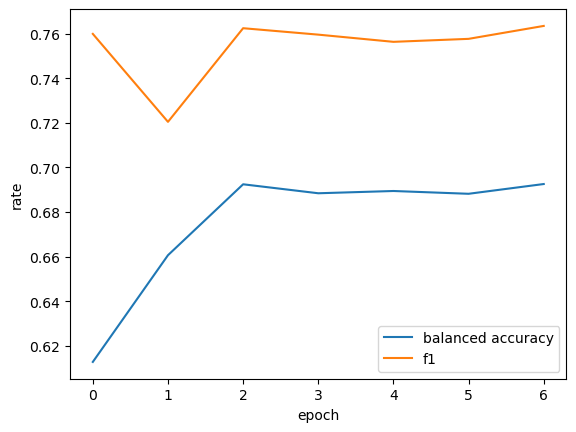

In [49]:
from matplotlib import pyplot as plt
num_epochs = 6

plt.plot(range(num_epochs + 1), [dn_acc_pretrained, *dn_accs_by_epochs[:num_epochs]],
        label='balanced accuracy')
plt.plot(range(num_epochs + 1), [dn_f1_pretrained, *dn_f1_by_epochs[:num_epochs]],
        label='f1')
plt.xlabel('epoch')
plt.ylabel('rate')
plt.legend()

In [59]:
with torch.no_grad():
    rn_y_true, rn_y_pred, rn_y_probs = get_predictions_and_labels(test_loader, resnet)

100%|██████████| 1600/1600 [02:49<00:00,  9.41it/s]


In [60]:
with torch.no_grad():
    dn_y_true, dn_y_pred, dn_y_probs = get_predictions_and_labels(test_loader, densenet)

100%|██████████| 1600/1600 [03:05<00:00,  8.62it/s]


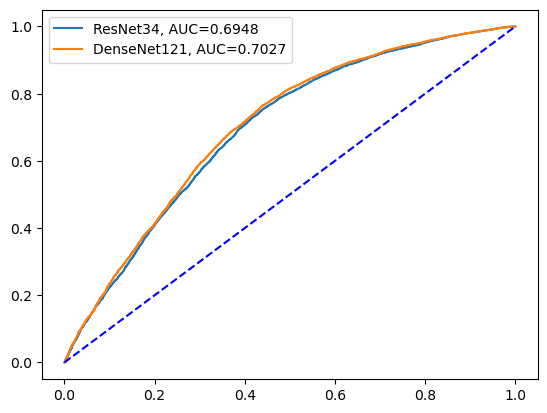

In [69]:
from sklearn import metrics

fpr, tpr, _ = metrics.roc_curve(rn_y_true, rn_y_probs)
auc = round(metrics.roc_auc_score(rn_y_true, rn_y_probs), 4)
plt.plot(fpr,tpr,label="ResNet34, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(dn_y_true, dn_y_probs)
auc = round(metrics.roc_auc_score(dn_y_true, dn_y_probs), 4)
plt.plot(fpr,tpr,label="DenseNet121, AUC="+str(auc))

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), 'b--')
plt.legend()

# Training Inception V3

In [148]:
def train_epoch_inception(loader, model, optimizer, loss_fn, epoch):
    model.train()
    
    losses = []
    i = 0
    running_loss = 0.
    for images, labels, in tqdm(loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        
        outputs, aux_outputs = model(images)
        outputs = nn.Sigmoid()(outputs).to(DEVICE)
        aux_outputs = nn.Sigmoid()(aux_outputs).to(DEVICE)
        loss1 = loss_fn(outputs, labels)
        loss2 = loss_fn(aux_outputs, labels)
        loss = loss1 + 0.2*loss2
#         outputs = nn.Sigmoid()(model(images)).to(DEVICE)
#         loss = loss_fn(outputs, labels)
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 200 == 199:
            last_loss = running_loss / 200 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.
        i += 1
        
    print(f'=> Epoch[{epoch}]: Mean Loss = {np.mean(losses)}')
    
    return np.mean(losses)

In [36]:
inc = torchvision.models.inception_v3(pretrained=True)
inc.AuxLogits.fc = nn.Linear(in_features=768, out_features=1, bias=True)
inc.fc = nn.Linear(in_features=2048, out_features=1, bias=True)
inc.to(DEVICE)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 60.5MB/s] 


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score

with torch.no_grad():
        inc_y_true, inc_y_pred, inc_y_probs = get_predictions_and_labels(test_loader, inc)
        
        inc_acc_pretrained = accuracy_score(inc_y_true, inc_y_pred)
        print(f'accuracy: {inc_acc_pretrained}\n')
        
        inc_bal_acc_pretrained = balanced_accuracy_score(inc_y_true, inc_y_pred)
        print(f'balanced accuracy: {inc_bal_acc_pretrained}\n')
        
        inc_prec_pretrained = precision_score(inc_y_true, inc_y_pred)
        print(f'precision: {inc_prec_pretrained}\n')
        
        inc_rec_pretrained = recall_score(inc_y_true, inc_y_pred)
        print(f'recall: {inc_rec_pretrained}\n')

        inc_f1_pretrained = f1_score(inc_y_true, inc_y_pred)
        print(f'f1: {inc_f1_pretrained}\n')

100%|██████████| 1600/1600 [05:18<00:00,  5.02it/s]


accuracy: 0.5995858727926239

balanced accuracy: 0.5123876648554718

precision: 0.6193613563491017

recall: 0.8990691150216782

f1: 0.7334529661127149



In [154]:
best_inc_f1 = 0.22

In [155]:
inc_losses = []

inc_accs_by_epochs = []

inc_bal_accs_by_epochs = []

inc_precs_by_epochs = []

inc_recs_by_epochs = []

inc_f1_by_epochs = []

In [157]:
optimizer = optim.SGD(inc.parameters(), lr=1e-4, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.1)
loss_fn = nn.BCELoss()

In [ ]:
for epoch in range(25):
    loss = train_epoch_inception(
        train_loader,
        inc,
        optimizer,
        loss_fn,
        epoch + 1
    )
    
    with torch.no_grad():
        y_true, y_pred, y_probs = get_predictions_and_labels(test_loader, inc)
        
        inc_acc = accuracy_score(y_true, y_pred)
        
        print(f'accuracy: {inc_acc}\n')
        
        inc_bal_acc = balanced_accuracy_score(y_true, y_pred)
        
        print(f'balanced accuracy: {inc_bal_acc}\n')
        
        inc_prec = precision_score(y_true, y_pred)
        
        print(f'precision: {inc_prec}\n')
        
        inc_rec = recall_score(y_true, y_pred)
        
        print(f'recall: {inc_rec}\n')
        
        inc_f1 = f1_score(y_true, y_pred)

        print(f'f1: {inc_f1}\n')
        
        
        inc_bal_accs_by_epochs.append(inc_bal_acc)
        inc_accs_by_epochs.append(inc_acc)
        inc_precs_by_epochs.append(inc_prec)
        inc_recs_by_epochs.append(inc_rec)
        inc_f1_by_epochs.append(inc_f1)
        
        torch.save(inc_bal_accs_by_epochs, './inc_bal_accs_by_epochs.pt')
        torch.save(inc_accs_by_epochs, './inc_accs_by_epochs.pt')
        torch.save(inc_precs_by_epochs, './inc_precs_by_epochs.pt')
        torch.save(inc_recs_by_epochs, './inc_recs_by_epochs.pt')
        torch.save(inc_f1_by_epochs, './inc_f1_by_epochs.pt')
        
        if inc_f1 > best_inc_f1:
            torch.save(inc.state_dict(), f'./inc_weights_f1_{inc_f1}.pt')
            best_inc_f1 = inc_f1
        
    inc_losses.append(loss)

  7%|▋         | 200/2704 [01:30<19:05,  2.19it/s]

  batch 200 loss: 0.8097177076339722


 15%|█▍        | 400/2704 [03:02<17:40,  2.17it/s]

  batch 400 loss: 0.8061348393559455


 22%|██▏       | 600/2704 [04:33<15:51,  2.21it/s]

  batch 600 loss: 0.7886001375317574


 30%|██▉       | 800/2704 [06:04<14:21,  2.21it/s]

  batch 800 loss: 0.7844273638725281


 37%|███▋      | 1000/2704 [07:36<12:50,  2.21it/s]

  batch 1000 loss: 0.7704586097598076


 44%|████▍     | 1200/2704 [09:07<11:40,  2.15it/s]

  batch 1200 loss: 0.7628112137317657


 52%|█████▏    | 1400/2704 [10:38<09:46,  2.22it/s]

  batch 1400 loss: 0.7615396746993065


 59%|█████▉    | 1600/2704 [12:10<08:19,  2.21it/s]

  batch 1600 loss: 0.7611868178844452


 67%|██████▋   | 1800/2704 [13:42<06:46,  2.22it/s]

  batch 1800 loss: 0.754099535048008


 74%|███████▍  | 2000/2704 [15:13<05:15,  2.23it/s]

  batch 2000 loss: 0.737865983247757


 81%|████████▏ | 2200/2704 [16:45<03:55,  2.14it/s]

  batch 2200 loss: 0.748916029036045


 89%|████████▉ | 2400/2704 [18:18<02:17,  2.22it/s]

  batch 2400 loss: 0.7411660093069077


 96%|█████████▌| 2600/2704 [19:50<00:47,  2.20it/s]

  batch 2600 loss: 0.7433758297562599


100%|██████████| 2704/2704 [20:37<00:00,  2.19it/s]


=> Epoch[1]: Mean Loss = 0.7655148109388069


100%|██████████| 1600/1600 [03:06<00:00,  8.58it/s]


accuracy: 0.6667448038756055

balanced accuracy: 0.6407032999809186

precision: 0.7159241820596403

recall: 0.7561846467737822

f1: 0.7355038759689922



  7%|▋         | 200/2704 [01:29<18:27,  2.26it/s]

  batch 200 loss: 0.7381005492806435


 15%|█▍        | 400/2704 [02:59<17:06,  2.25it/s]

  batch 400 loss: 0.7309079280495644


 22%|██▏       | 600/2704 [04:29<15:46,  2.22it/s]

  batch 600 loss: 0.7297313711047173


 30%|██▉       | 800/2704 [06:00<14:14,  2.23it/s]

  batch 800 loss: 0.7309738159179687


 37%|███▋      | 1000/2704 [07:31<13:21,  2.13it/s]

  batch 1000 loss: 0.72513153642416


 44%|████▍     | 1200/2704 [09:03<11:27,  2.19it/s]

  batch 1200 loss: 0.7241796377301216


 52%|█████▏    | 1400/2704 [10:35<10:33,  2.06it/s]

  batch 1400 loss: 0.7184895351529121


 59%|█████▉    | 1600/2704 [12:07<08:35,  2.14it/s]

  batch 1600 loss: 0.7279937827587127


 67%|██████▋   | 1800/2704 [13:38<06:52,  2.19it/s]

  batch 1800 loss: 0.7230764132738113


 74%|███████▍  | 2000/2704 [15:10<05:20,  2.20it/s]

  batch 2000 loss: 0.7163652738928795


 81%|████████▏ | 2200/2704 [16:42<03:55,  2.14it/s]

  batch 2200 loss: 0.7131940697133541


 89%|████████▉ | 2400/2704 [18:14<02:18,  2.19it/s]

  batch 2400 loss: 0.7184503102302551


 96%|█████████▌| 2600/2704 [19:45<00:47,  2.20it/s]

  batch 2600 loss: 0.7185355073213577


100%|██████████| 2704/2704 [20:33<00:00,  2.19it/s]


=> Epoch[2]: Mean Loss = 0.7247204284277364


100%|██████████| 1600/1600 [03:08<00:00,  8.50it/s]


accuracy: 0.6774886701047038

balanced accuracy: 0.6519021173627078

precision: 0.7240484950841426

recall: 0.7653659780668197

f1: 0.7441341474754363



  7%|▋         | 200/2704 [01:29<18:25,  2.26it/s]

  batch 200 loss: 0.7035106462240219


 15%|█▍        | 400/2704 [02:58<16:54,  2.27it/s]

  batch 400 loss: 0.7071581219136714


 22%|██▏       | 600/2704 [04:28<15:36,  2.25it/s]

  batch 600 loss: 0.720825055539608


 30%|██▉       | 800/2704 [05:58<14:09,  2.24it/s]

  batch 800 loss: 0.7015843831002713


 37%|███▋      | 1000/2704 [07:28<12:46,  2.22it/s]

  batch 1000 loss: 0.7037121568620205


 44%|████▍     | 1200/2704 [08:59<11:43,  2.14it/s]

  batch 1200 loss: 0.708331844508648


 52%|█████▏    | 1400/2704 [10:30<09:46,  2.22it/s]

  batch 1400 loss: 0.7011817525327205


 59%|█████▉    | 1600/2704 [12:01<08:14,  2.23it/s]

  batch 1600 loss: 0.7221176400780678


 67%|██████▋   | 1800/2704 [13:33<06:58,  2.16it/s]

  batch 1800 loss: 0.7112114608287812


 74%|███████▍  | 2000/2704 [15:04<05:22,  2.19it/s]

  batch 2000 loss: 0.7153396713733673


 81%|████████▏ | 2200/2704 [16:36<03:47,  2.22it/s]

  batch 2200 loss: 0.7150740537047386


 89%|████████▉ | 2400/2704 [18:07<02:18,  2.20it/s]

  batch 2400 loss: 0.7089661084115505


 96%|█████████▌| 2600/2704 [19:38<00:46,  2.22it/s]

  batch 2600 loss: 0.7052587661147117


100%|██████████| 2704/2704 [20:26<00:00,  2.20it/s]


=> Epoch[3]: Mean Loss = 0.7091743432580543


100%|██████████| 1600/1600 [03:07<00:00,  8.55it/s]


accuracy: 0.6912017502734802

balanced accuracy: 0.646792423672619

precision: 0.7081772449962539

recall: 0.8437260902830911

f1: 0.7700320046552226



  7%|▋         | 200/2704 [01:27<18:18,  2.28it/s]

  batch 200 loss: 0.7013998050987721


 15%|█▍        | 400/2704 [02:55<16:45,  2.29it/s]

  batch 400 loss: 0.7023667021095753


 22%|██▏       | 600/2704 [04:24<16:00,  2.19it/s]

  batch 600 loss: 0.7018413668870926


 30%|██▉       | 800/2704 [05:55<14:52,  2.13it/s]

  batch 800 loss: 0.6943879033625125


 37%|███▋      | 1000/2704 [07:25<12:38,  2.25it/s]

  batch 1000 loss: 0.6937301938235759


 44%|████▍     | 1200/2704 [08:56<11:10,  2.24it/s]

  batch 1200 loss: 0.6876283873617649


 52%|█████▏    | 1400/2704 [10:27<09:51,  2.21it/s]

  batch 1400 loss: 0.7007490128278733


 59%|█████▉    | 1600/2704 [11:59<08:21,  2.20it/s]

  batch 1600 loss: 0.7043950481712818


 67%|██████▋   | 1800/2704 [13:31<06:54,  2.18it/s]

  batch 1800 loss: 0.6955390334129333


 74%|███████▍  | 2000/2704 [15:02<05:18,  2.21it/s]

  batch 2000 loss: 0.6948927016556263


 81%|████████▏ | 2200/2704 [16:34<03:52,  2.17it/s]

  batch 2200 loss: 0.6969644293189049


 89%|████████▉ | 2400/2704 [18:06<02:18,  2.20it/s]

  batch 2400 loss: 0.6943580803275108


 96%|█████████▌| 2600/2704 [19:38<00:47,  2.21it/s]

  batch 2600 loss: 0.7028069445490837


100%|██████████| 2704/2704 [20:25<00:00,  2.21it/s]


=> Epoch[4]: Mean Loss = 0.6983703467333634


100%|██████████| 1600/1600 [03:08<00:00,  8.51it/s]


accuracy: 0.6858102828566963

balanced accuracy: 0.6576900056379846

precision: 0.726094674556213

recall: 0.7823896965059933

f1: 0.7531917505524183



  7%|▋         | 200/2704 [01:28<18:40,  2.24it/s]

  batch 200 loss: 0.6969292332231999


 15%|█▍        | 400/2704 [02:58<17:06,  2.24it/s]

  batch 400 loss: 0.6818774597346783


 22%|██▏       | 600/2704 [04:28<15:40,  2.24it/s]

  batch 600 loss: 0.6894503420591355


 30%|██▉       | 800/2704 [05:59<15:08,  2.10it/s]

  batch 800 loss: 0.6820886114239693


 37%|███▋      | 1000/2704 [07:29<12:46,  2.22it/s]

  batch 1000 loss: 0.6941507822275161


 44%|████▍     | 1200/2704 [09:01<11:17,  2.22it/s]

  batch 1200 loss: 0.6936504563689232


 52%|█████▏    | 1400/2704 [10:32<09:44,  2.23it/s]

  batch 1400 loss: 0.6763018196821213


 59%|█████▉    | 1600/2704 [12:03<08:39,  2.13it/s]

  batch 1600 loss: 0.6869550889730454


 67%|██████▋   | 1800/2704 [13:36<06:54,  2.18it/s]

  batch 1800 loss: 0.6943192990124225


 74%|███████▍  | 2000/2704 [15:07<05:19,  2.20it/s]

  batch 2000 loss: 0.683368244767189


 81%|████████▏ | 2200/2704 [16:39<03:48,  2.20it/s]

  batch 2200 loss: 0.6928601738810539


 89%|████████▉ | 2400/2704 [18:11<02:17,  2.21it/s]

  batch 2400 loss: 0.6858529798686505


 96%|█████████▌| 2600/2704 [19:43<00:47,  2.20it/s]

  batch 2600 loss: 0.6740420871973037


100%|██████████| 2704/2704 [20:30<00:00,  2.20it/s]


=> Epoch[5]: Mean Loss = 0.6870403994293608


100%|██████████| 1600/1600 [03:14<00:00,  8.22it/s]


accuracy: 0.6884278793561494

balanced accuracy: 0.6541267052124495

precision: 0.7192423639155907

recall: 0.8062356541698547

f1: 0.7602585299864724



  7%|▋         | 200/2704 [01:29<18:34,  2.25it/s]

  batch 200 loss: 0.6798949490487576


 15%|█▍        | 400/2704 [02:58<17:22,  2.21it/s]

  batch 400 loss: 0.6794329604506493


 22%|██▏       | 600/2704 [04:27<15:44,  2.23it/s]

  batch 600 loss: 0.6752430261671543


 30%|██▉       | 800/2704 [05:58<14:07,  2.25it/s]

  batch 800 loss: 0.6808208456635475


 37%|███▋      | 1000/2704 [07:28<13:51,  2.05it/s]

  batch 1000 loss: 0.6692758966982365


 44%|████▍     | 1200/2704 [08:58<11:22,  2.21it/s]

  batch 1200 loss: 0.6762341338396073


 52%|█████▏    | 1400/2704 [10:30<09:52,  2.20it/s]

  batch 1400 loss: 0.6747944563627243


 59%|█████▉    | 1600/2704 [12:01<08:20,  2.21it/s]

  batch 1600 loss: 0.6878191702067852


 67%|██████▋   | 1800/2704 [13:33<06:45,  2.23it/s]

  batch 1800 loss: 0.6784115599095821


 74%|███████▍  | 2000/2704 [15:05<05:22,  2.18it/s]

  batch 2000 loss: 0.673040369451046


 81%|████████▏ | 2200/2704 [16:37<03:48,  2.20it/s]

  batch 2200 loss: 0.6668585933744907


 89%|████████▉ | 2400/2704 [18:09<02:18,  2.19it/s]

  batch 2400 loss: 0.6700921538472175


 96%|█████████▌| 2600/2704 [19:40<00:47,  2.18it/s]

  batch 2600 loss: 0.6679173550009727


100%|██████████| 2704/2704 [20:28<00:00,  2.20it/s]


=> Epoch[6]: Mean Loss = 0.6752310918544876


100%|██████████| 1600/1600 [03:07<00:00,  8.55it/s]


accuracy: 0.689443663072355

balanced accuracy: 0.6519481614180302

precision: 0.7156879147844515

recall: 0.8182223922468758

f1: 0.7635281868213596



  7%|▋         | 200/2704 [01:27<18:04,  2.31it/s]

  batch 200 loss: 0.6661486744880676


 15%|█▍        | 400/2704 [02:56<17:03,  2.25it/s]

  batch 400 loss: 0.6654325488209725


 22%|██▏       | 600/2704 [04:24<15:49,  2.22it/s]

  batch 600 loss: 0.6568327637016773


 30%|██▉       | 800/2704 [05:53<13:55,  2.28it/s]

  batch 800 loss: 0.6681920282542706


 37%|███▋      | 1000/2704 [07:23<12:39,  2.24it/s]

  batch 1000 loss: 0.667268045693636


 44%|████▍     | 1200/2704 [08:53<11:22,  2.20it/s]

  batch 1200 loss: 0.6592822249233723


 52%|█████▏    | 1400/2704 [10:23<09:49,  2.21it/s]

  batch 1400 loss: 0.6599927087128162


 59%|█████▉    | 1600/2704 [11:54<08:16,  2.22it/s]

  batch 1600 loss: 0.6573388844728469


 67%|██████▋   | 1800/2704 [13:24<06:47,  2.22it/s]

  batch 1800 loss: 0.6487457160651684


 74%|███████▍  | 2000/2704 [14:56<05:21,  2.19it/s]

  batch 2000 loss: 0.6701891872286797


 81%|████████▏ | 2200/2704 [16:27<03:59,  2.10it/s]

  batch 2200 loss: 0.6685711005330086


 89%|████████▉ | 2400/2704 [17:59<02:21,  2.14it/s]

  batch 2400 loss: 0.6609351436793804


 96%|█████████▌| 2600/2704 [19:31<00:48,  2.16it/s]

  batch 2600 loss: 0.6620804546773433


100%|██████████| 2704/2704 [20:19<00:00,  2.22it/s]


=> Epoch[7]: Mean Loss = 0.6624023867826138


100%|██████████| 1600/1600 [03:07<00:00,  8.52it/s]


accuracy: 0.6896390060947023

balanced accuracy: 0.651364988177523

precision: 0.7148090586145648

recall: 0.82109155827595

f1: 0.764272997032641



  7%|▋         | 200/2704 [01:30<18:49,  2.22it/s]

  batch 200 loss: 0.6521388511359691


 15%|█▍        | 400/2704 [03:02<17:36,  2.18it/s]

  batch 400 loss: 0.6500166940689087


 22%|██▏       | 600/2704 [04:33<16:04,  2.18it/s]

  batch 600 loss: 0.6408855499327183


 30%|██▉       | 800/2704 [06:04<14:14,  2.23it/s]

  batch 800 loss: 0.6452876210212708


 31%|███       | 836/2704 [06:21<14:14,  2.19it/s]

# Evaluatin InceptionV3

In [39]:
inc_accs_by_epochs = torch.load('/kaggle/working/inc_accs_by_epochs.pt')

inc_bal_accs_by_epochs = torch.load('/kaggle/working/inc_bal_accs_by_epochs.pt')

inc_precs_by_epochs = torch.load('/kaggle/working/inc_precs_by_epochs.pt')

inc_recs_by_epochs = torch.load('/kaggle/working/inc_recs_by_epochs.pt')

inc_f1_by_epochs = torch.load('/kaggle/working/inc_f1_by_epochs.pt')

In [46]:
inc_recs_by_epochs

[0.7561846467737822,
 0.7653659780668197,
 0.8437260902830911,
 0.7823896965059933,
 0.8062356541698547,
 0.8182223922468758,
 0.82109155827595,
 0.7871716398877837,
 0.798457026268809,
 0.7707855138995154]

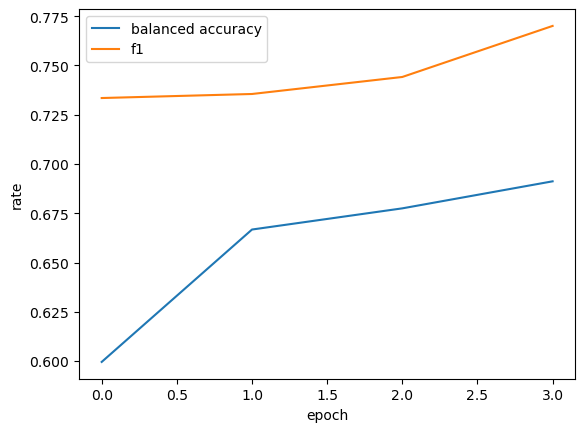

In [42]:
from matplotlib import pyplot as plt
num_epochs = 3

plt.plot(range(num_epochs + 1), [inc_acc_pretrained, *inc_accs_by_epochs[:num_epochs]],
        label='balanced accuracy')
plt.plot(range(num_epochs + 1), [inc_f1_pretrained, *inc_f1_by_epochs[:num_epochs]],
        label='f1')
plt.xlabel('epoch')
plt.ylabel('rate')
plt.legend()

# Comparing all 3 models using ROC curve

In [51]:
resnet.load_state_dict(torch.load('/kaggle/working/weights_f1_0.7689501418727199.pt'))
densenet.load_state_dict(torch.load('/kaggle/working/dn_weights_f1_0.7634735038624546.pt'))
inc.load_state_dict(torch.load('/kaggle/working/inc_weights_f1_0.7700320046552226.pt'))

<All keys matched successfully>

In [52]:
with torch.no_grad():
    rn_y_true, rn_y_pred, rn_y_probs = get_predictions_and_labels(test_loader, resnet)
    dn_y_true, dn_y_pred, dn_y_probs = get_predictions_and_labels(test_loader, densenet)
    inc_y_true, inc_y_pred, inc_y_probs = get_predictions_and_labels(test_loader, inc)

100%|██████████| 1600/1600 [02:45<00:00,  9.69it/s]


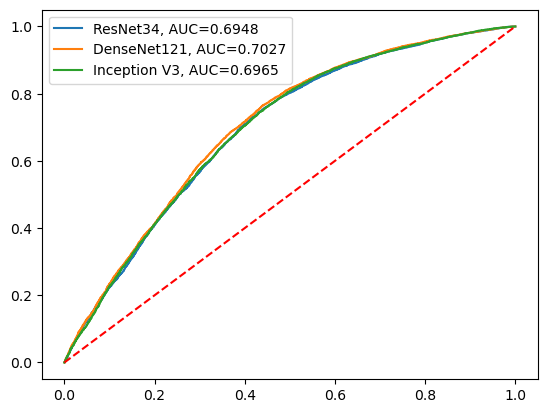

In [65]:
from sklearn import metrics

# plt.figure(figsize=(10, 10))

fpr, tpr, _ = metrics.roc_curve(rn_y_true, rn_y_probs)
auc = round(metrics.roc_auc_score(rn_y_true, rn_y_probs), 4)
plt.plot(fpr,tpr,label="ResNet34, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(dn_y_true, dn_y_probs)
auc = round(metrics.roc_auc_score(dn_y_true, dn_y_probs), 4)
plt.plot(fpr,tpr,label="DenseNet121, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(inc_y_true, inc_y_probs)
auc = round(metrics.roc_auc_score(inc_y_true, inc_y_probs), 4)
plt.plot(fpr,tpr,label="Inception V3, AUC="+str(auc))

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), 'r--')

plt.legend()